# Kaggle上的titanic disaster数据分类问题

**题目中提到的重要信息：**
* 这是一个二分类问题，根据旅客的信息判断旅客是否可以在这场灾难中存活下来（0 = No, 1 = Yes）
* 存活下来除了有运气的成分之外，有一些人更有可能存活下来：women、children、the upper-class

根据参考文献[1]中的内容，计划workflow如下：
1. 数据集清理和格式化
2. 探索性数据分析
3. 特征工程和特征选择
4. 基于性能指标比较几种机器学习模型
5. 对最佳模型执行超参数调整
6. 在测试集上评估最佳模型
7. 解释模型结果
8. 得出结论

# Imports

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size']=24

from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(font_scale=1.5)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. 数据处理
## 1.1 加载数据

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**这里是数据中每一个字段的具体含义：**

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
|survival	|Survival	|0 = No, 1 = Yes|
|pclass	|Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	|
|Age	|Age in years|	
|sibsp	|# of siblings / spouses aboard the Titanic	|
|parch	|# of parents / children aboard the Titanic	|
|ticket	|Ticket number	|
|fare	|Passenger fare	|
|cabin	|Cabin number	|
|embarked	|Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton|

**题目中的Overview中提到了，women、children、the upper-class存活下来的概率更大，所以接下来，我们可能要更加注重pclass、sex、age这三个字段**

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


使用data.info()看到，所有的列都使用了正确的数据类型，并没有出现包含数字的列被存储为object类型

## 1.2 处理异常值


In [4]:
# 使用data.describe()查看数据的统计信息
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0.5,1,'Survival Distribution')

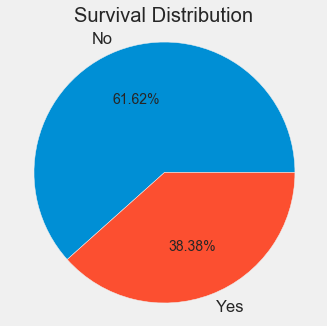

In [5]:
figsize(5,5)
plt.style.use('fivethirtyeight')
counts = train_data['Survived'].value_counts()
plt.pie(counts, labels=['No', 'Yes'], autopct='%1.2f%%')
plt.axis('equal')
plt.title('Survival Distribution')

Text(0.5,1,'Age Distribution')

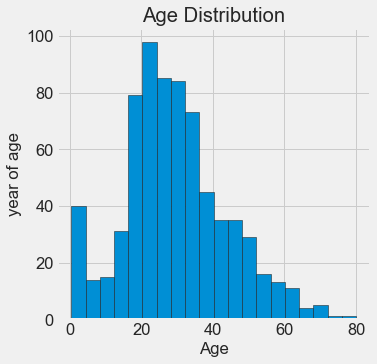

In [6]:
figsize(5,5)
plt.hist(train_data['Age'].dropna(), bins=20, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('year of age')
plt.title('Age Distribution')

Text(0.5,1,'Ticket Class Distribution')

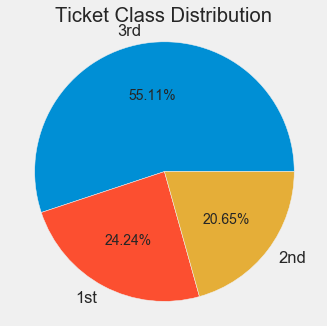

In [7]:
figsize(5,5)
counts = train_data['Pclass'].value_counts()
plt.pie(counts, labels=['3rd', '1st', '2nd'], autopct='%1.2f%%')
plt.axis('equal')
plt.title('Ticket Class Distribution')

male      577
female    314
Name: Sex, dtype: int64


Text(0.5,1,'Sex Distribution')

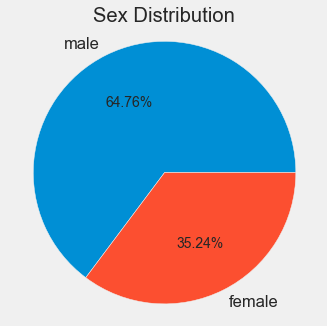

In [8]:
figsize(5,5)
counts = train_data['Sex'].value_counts()
print(counts)
plt.pie(counts, labels=['male', 'female'], autopct='%1.2f%%')
plt.axis('equal')
plt.title('Sex Distribution')

## 1.3 处理缺失值

In [9]:
print('Train columns with null values:\n', train_data.isnull().sum() / train_data.shape[0])
print("-"*10)

print('Test/Validation columns with null values:\n', test_data.isnull().sum() / test_data.shape[0])
print("-"*10)

Train columns with null values:
 PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64
----------
Test/Validation columns with null values:
 PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64
----------


In [10]:
for dataset in [train_data, test_data]:    
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
drop_column = ['Cabin','PassengerId', 'Ticket']
train_data.drop(drop_column, axis=1, inplace = True)

print(train_data.isnull().sum())
print("-"*10)
print(test_data.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


# 2. 特征工程与特征选择

## 2.2 特征工程

In [11]:
def create_features_for_data(data):
    data['FamilySize'] = data ['SibSp'] + data['Parch'] + 1
    
    data['IsAlone'] = 1
    data['IsAlone'].loc[data['FamilySize'] > 1] = 0 
    
    data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    title_names = (data['Title'].value_counts() < 10) 
    data['Title'] = data['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    
    data['FareBin'] = pd.qcut(data['Fare'], 4)
    data['AgeBin'] = pd.cut(data['Age'].astype(int), 5)
    
    label = LabelEncoder()
    features = ['Sex', 'Embarked', 'Title', 'FareBin', 'AgeBin']
    for f in features:
        data[f+'_Code'] = label.fit_transform(data[f])
    
    data = data.drop(columns=['Sex', 'Embarked', 'Title', 'FareBin', 'AgeBin', 'Name'])
    return data

train_data = create_features_for_data(train_data)
test_data = create_features_for_data(test_data)
print('train data shape:',train_data.shape)
train_data.head(5)

train data shape: (891, 13)


,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_Code,Embarked_Code,Title_Code,FareBin_Code,AgeBin_Code
0,0,3,22.0,1,0,7.2500,2,0,1,2,3,0,1
1,1,1,38.0,1,0,71.2833,2,0,0,0,4,3,2
2,1,3,26.0,0,0,7.9250,1,1,0,2,2,1,1
3,1,1,35.0,1,0,53.1000,2,0,0,2,4,3,2
4,0,3,35.0,0,0,8.0500,1,1,1,2,3,1,2


## 2.3 特征选择（去除共线特征）


In [12]:
def print_collinear_features(x, threshold):
    '''
    Objective:
       删除数据帧中相关系数大于阈值的共线特征。 删除共线特征可以帮助模型泛化并提高模型的可解释性。
        
    Inputs: 
        阈值：删除任何相关性大于此值的特征
    
    Output: 
        仅包含非高共线特征的数据帧
    '''
    
    # 不要删除能源之星得分之间的相关性
    y = x['Survived']
    x = x.drop(columns = ['Survived'])
    
    # 计算相关性矩阵
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # 迭代相关性矩阵并比较相关性
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # 如果相关性超过阈值
            if val >= threshold:
                # 打印有相关性的特征和相关值
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])


In [13]:
print_collinear_features(train_data, 0.6)

FamilySize | SibSp | 0.89
FamilySize | Parch | 0.78
FareBin_Code | Pclass | 0.63
AgeBin_Code | Age | 0.94


In [14]:
drop_columns = ['Age', 'SibSp', 'Parch']
train_data = train_data.drop(columns=drop_columns)
test_data = test_data.drop(columns=drop_columns)
print('train data shape:',train_data.shape)
train_data.head(5)

train data shape: (891, 10)


,Survived,Pclass,Fare,FamilySize,IsAlone,Sex_Code,Embarked_Code,Title_Code,FareBin_Code,AgeBin_Code
0,0,3,7.2500,2,0,1,2,3,0,1
1,1,1,71.2833,2,0,0,0,4,3,2
2,1,3,7.9250,1,1,0,2,2,1,1
3,1,1,53.1000,2,0,0,2,4,3,2
4,0,3,8.0500,1,1,1,2,3,1,2


## 2.3 特征缩放

In [15]:
# max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
# train_data[['Age', 'Fare']] = train_data[['Age', 'Fare']].apply(max_min_scaler)
# train_data.head(5)

## 2.4 划分训练集合测试集

In [16]:
targets = train_data[['Survived']]
features = train_data.drop(columns=['Survived'])

X, X_valid, Y, Y_valid = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(Y.shape)
print(X_valid.shape)
print(Y_valid.shape)

X.to_csv('X.csv', index=False)
Y.to_csv('Y.csv', index=False)

Y = np.array(Y).reshape((-1, ))
Y_valid = np.array(Y_valid).reshape((-1, ))

(623, 9)
(623, 1)
(268, 9)
(268, 1)



# 3 对数据进行探索性分析


In [17]:
correlations_matrix = train_data.corr()['Survived'].sort_values()
print(correlations_matrix, '\n')

Sex_Code        -0.543351
Pclass          -0.338481
IsAlone         -0.203367
Embarked_Code   -0.167675
Title_Code      -0.083292
AgeBin_Code     -0.044492
FamilySize       0.016639
Fare             0.257307
FareBin_Code     0.299357
Survived         1.000000
Name: Survived, dtype: float64 



In [18]:
for x in train_data:
    if train_data[x].dtype != 'float64' and x not in ['Survived', 'Name']:
        print('Survival Correlation by:', x)
        print(train_data[[x, 'Survived']].groupby(x, as_index=False).mean())
        print('-' * 10, '\n')

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
---------- 

Survival Correlation by: IsAlone
   IsAlone  Survived
0        0  0.505650
1        1  0.303538
---------- 

Survival Correlation by: Sex_Code
   Sex_Code  Survived
0         0  0.742038
1         1  0.188908
---------- 

Survival Correlation by: Embarked_Code
   Embarked_Code  Survived
0              0  0.553571
1              1  0.389610
2              2  0.339009
---------- 

Survival Correlation by: Title_Code
   Title_Code  Survived
0           0  0.575000
1           1  0.444444
2           2  0.697802
3           3  0.156673
4           4  0.792000
---------- 

Survival Co

# 4.基于性能指标比较几种机器学习模型

In [19]:
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn import model_selection
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
import scipy.stats
import json

## 4.1 建立Baseline

In [20]:
baseline_accuracy = 1 - np.sum(targets)/targets.shape[0]
print('The baseline guess is %d' % 0)
print("Baseline Performance on the test set: accuracy = %0.4f" % baseline_accuracy)

The baseline guess is 0
Baseline Performance on the test set: accuracy = 0.6162


## 4.2 需要评估的模型

In [21]:
# machine learning algorithm
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators=10),
    ensemble.BaggingClassifier(n_estimators=10),
    ensemble.ExtraTreesClassifier(n_estimators=10),
    ensemble.GradientBoostingClassifier(n_estimators=10),
    ensemble.RandomForestClassifier(n_estimators=10),

#     Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(cv=3, max_iter=1000),
    linear_model.PassiveAggressiveClassifier(max_iter=1000, tol=1e-3),
    linear_model.RidgeClassifierCV(cv=3),
    linear_model.SGDClassifier(max_iter=1000, tol=1e-3),
    linear_model.Perceptron(max_iter=1000, tol=1e-3),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True, gamma='scale'),
    svm.NuSVC(probability=True, gamma='scale'),
#     svm.LinearSVC(max_iter=1000),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis()
]

In [22]:
n_estimators = scipy.stats.randint(low=10, high=1000)
learning_rate = scipy.stats.uniform(loc=0.01, scale=1.0-0.01)
ratio = scipy.stats.uniform(loc=0.1, scale=1.0-0.1)
min_samples_leaf = [1,2,4,6,8]
min_samples_split = [2, 4, 6, 10]
cv = [3, 5, None]
max_depth = [2,4,6,8,10,None]
max_features = ['auto', 'sqrt', 'log2', None]
bool_value = [True, False]

hyperparameter_list = [
    # AdaBoostClassifier
    {'n_estimators': n_estimators, 'algorithm':['SAMME', 'SAMME.R'], 'learning_rate':learning_rate},
    # BaggingClassifier
    {'n_estimators': n_estimators, 'max_samples': ratio},
    # ExtraTreesClassifier
    {'n_estimators': n_estimators, 'criterion': ['gini', 'entropy'], 'max_depth': max_depth,
     'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features':max_features},
    # GradientBoostingClassifier
    {'loss': ['deviance', 'exponential'], 'learning_rate': learning_rate, 'n_estimators': n_estimators,
     'criterion':['friedman_mse', 'mse', 'mae'], 'min_samples_split':min_samples_split, 'min_samples_leaf': min_samples_leaf,
    'max_depth':max_depth, 'max_features':max_features},
    # RandomForestClassifier
    {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf,
     'min_samples_split': min_samples_split,'max_features': max_features, },
    # GaussianProcessClassifier
    {'max_iter_predict': n_estimators},
    # LogisticRegressionCV
    {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'cv': cv, 'fit_intercept': bool_value},
    # PassiveAggressiveClassifier
    {'fit_intercept': bool_value, 'loss': ['hinge', 'squared_hinge']},
    # RidgeClassifierCV
    {'fit_intercept': bool_value, 'normalize': bool_value, 'cv': cv},
    # SGDClassifier
    {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': [None, 'l2', 'l1', 'elasticnet'], 'fit_intercept': bool_value},
    # Perceptron
    {'penalty': [None, 'l2', 'l1', 'elasticnet'], 'fit_intercept': bool_value },
    # BernoulliNB
    {'alpha': ratio},
    # GaussianNB
    {},
    # KNeighborsClassifier
    {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
    # SVC
    {'C': [1, 2, 3, 4, 5], 'gamma': ratio, 'decision_function_shape': ['ovo', 'ovr'], 'probability': [True]},
    # NuSVC
    {'gamma': ratio,  'probability': [True], 'decision_function_shape': ['ovo', 'ovr']},
    # DecisionTreeClassifier
    {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': max_depth,
     'min_samples_split':min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features},
    # ExtraTreeClassifier
    {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': max_depth,
     'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features},
    # LinearDiscriminantAnalysis
    {'solver': ['svd', 'lsqr', 'eigen']},
    # QuadraticDiscriminantAnalysis
    {}
]

In [23]:
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean',
               'MLA Test Accuracy STD']
MLA_compare = pd.DataFrame(columns=MLA_columns)
row_index = 0
for model, param in zip(MLA, hyperparameter_list):
    random_search = model_selection.RandomizedSearchCV(estimator=model,
                                                       param_distributions=param,
                                                       cv=4, n_iter=25, scoring='accuracy',
                                                       n_jobs=-1, verbose=1,
                                                       return_train_score=True,
                                                       random_state=0)
    MLA_name = model.__class__.__name__
    print('random_search for: %s' % MLA_name)
    random_search.fit(X, Y)
    cv_results = random_search.cv_results_
    best_index = random_search.best_index_
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = json.dumps(cv_results['params'][best_index])
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['mean_train_score'][best_index]
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['mean_test_score'][best_index]
    MLA_compare.loc[row_index, 'MLA Test Accuracy STD'] = cv_results['std_test_score'][best_index]

    row_index += 1
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)

random_search for: AdaBoostClassifier
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished


random_search for: BaggingClassifier
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: ExtraTreesClassifier
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.3s finished


random_search for: GradientBoostingClassifier
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: RandomForestClassifier
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: GaussianProcessClassifier
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished


random_search for: LogisticRegressionCV
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.0s finished


random_search for: PassiveAggressiveClassifier
Fitting 4 folds for each of 4 candidates, totalling 16 fits
random_search for: RidgeClassifierCV
Fitting 4 folds for each of 12 candidates, totalling 48 fits


c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=25. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.0s finished
c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 12 is smaller than n_iter=25. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(

random_search for: SGDClassifier
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=25. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: Perceptron
Fitting 4 folds for each of 8 candidates, totalling 32 fits
random_search for: BernoulliNB
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=25. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: GaussianNB
Fitting 4 folds for each of 1 candidates, totalling 4 fits
random_search for: KNeighborsClassifier
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: SVC
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: NuSVC
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: DecisionTreeClassifier
Fitting 4 folds for each of 25 candidates, totalling 100 fits
random_search for: ExtraTreeClassifier
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 3 is smaller than n_iter=25. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


random_search for: LinearDiscriminantAnalysis
Fitting 4 folds for each of 3 candidates, totalling 12 fits
random_search for: QuadraticDiscriminantAnalysis
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=25. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished


In [24]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy STD
1,BaggingClassifier,"{""n_estimators"": 125, ""max_samples"": 0.1784163...",0.876939,0.842697,0.006849
2,ExtraTreesClassifier,"{""max_depth"": 4, ""max_features"": null, ""criter...",0.84377,0.839486,0.0243024
4,RandomForestClassifier,"{""max_features"": null, ""max_depth"": 4, ""min_sa...",0.868382,0.834671,0.0205027
0,AdaBoostClassifier,"{""algorithm"": ""SAMME"", ""learning_rate"": 0.7234...",0.860886,0.833066,0.0133711
17,ExtraTreeClassifier,"{""max_depth"": 8, ""criterion"": ""gini"", ""max_fea...",0.866241,0.826645,0.0120118
3,GradientBoostingClassifier,"{""max_depth"": 2, ""loss"": ""exponential"", ""max_f...",0.869982,0.82504,0.0271037
16,DecisionTreeClassifier,"{""max_depth"": 10, ""criterion"": ""entropy"", ""max...",0.867312,0.82504,0.0094535
19,QuadraticDiscriminantAnalysis,{},0.83146,0.815409,0.0233235
6,LogisticRegressionCV,"{""cv"": 5, ""fit_intercept"": true, ""solver"": ""lb...",0.803643,0.799358,0.0332091
12,GaussianNB,{},0.79775,0.794543,0.0201163


Text(0,0.5,'Algorithm')

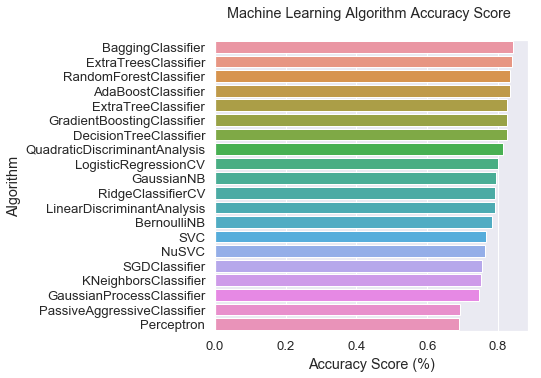

In [25]:
sns.set(font_scale=1.2)
sns.barplot(x = 'MLA Test Accuracy Mean', y = 'MLA Name', data=MLA_compare)
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

### 4.3.2 Grid Search CV

In [26]:
index = MLA_compare[MLA_compare['MLA Name']=='RandomForestClassifier'].index.tolist()[0]
model = MLA[index]
params = json.loads(MLA_compare['MLA Parameters'][index])
print(params)

{'max_features': None, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 207}


In [27]:
n_estimators = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
hyperparameter_grid = {'n_estimators': n_estimators}  
model = ensemble.RandomForestClassifier(**params)

grid_search = model_selection.GridSearchCV(estimator=model,
                                           param_grid=hyperparameter_grid, 
                                           cv = 4, scoring='accuracy',
                                           verbose = 1,
                                           n_jobs = -1, 
                                           return_train_score = True)

In [28]:
grid_search.fit(X, Y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.7s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=207, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [29]:
grid_search_result = pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending = False)
best_mean_test_score = grid_search_result['mean_test_score'][0]
print('best mean test score of grid search result is %0.4f' % best_mean_test_score)

best mean test score of grid search result is 0.8283


In [30]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## 4.4 在测试集上评估模型

In [31]:
def cal_accuracy(y_true, y_pred):
    return 1- np.sum(abs(y_true - y_pred)) / y_pred.shape[0]

final_model = grid_search.best_estimator_
final_pred = final_model.predict(X_valid)
accuracy = cal_accuracy(Y_valid, final_pred)
print('Final model performance on the test set:  accuracy = %0.4f.' % accuracy)

Final model performance on the test set:  accuracy = 0.8134.
